# Snake

In [1]:
import time

from helpers import *
from environments import *
import tensorflow as tf
from datetime import datetime
import json
import numpy as np
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import keras.api._v2.keras as K
import os
import numpy_indexed as npi

## Environment definition

In [2]:
# region models
input_ = K.layers.Input(shape=(BaseEnvironment.BOARD_SIZE, BaseEnvironment.BOARD_SIZE, 5))
x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(input_)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

encoder = K.Model(inputs=[input_], outputs=[x])

Metal device set to: Apple M1 Max


2022-12-29 21:03:46.526170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-29 21:03:46.526316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
policy = K.layers.Flatten()(encoder.output)
policy = K.layers.Dense(128, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(128, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=encoder.output, outputs=policy)

vf = K.layers.Flatten()(encoder.output)
vf = K.layers.Dense(128, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(128, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(4, activation=tf.nn.softmax)(vf)
value = K.models.Model(inputs=encoder.output, outputs=vf)


dec = K.layers.SpatialDropout2D(.4)(encoder.output)
dec = K.layers.Conv2DTranspose(32, 5, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.SpatialDropout2D(.4)(dec)
dec = K.layers.Conv2DTranspose(32, 5, activation=tf.nn.leaky_relu)(dec)
dec = K.layers.SpatialDropout2D(.4)(dec)
dec = K.layers.Conv2DTranspose(5, 5, activation=tf.nn.softmax)(dec)
decoder = K.models.Model(inputs=encoder.output, outputs=dec)

In [4]:
try:
    last_model_trained = sorted([ f.path for f in os.scandir(f'models/') if f.is_dir() ])[-1]
    agent.load_weights(last_model_trained+f"/agent")
    value.load_weights(last_model_trained+f"/value")
    encoder.load_weights(last_model_trained+f"/encoder")
    decoder.load_weights(last_model_trained+f"/decoder")
    print("loaded")
except:
    pass

loaded


## Training

In [5]:
env_ = NumpyEnvironment(1000)
env_.FRUIT_REWARD = .5
env_.ATE_HIMSELF_REWARD = .2
env_.WIN_REWARD = 1.
env_.STEP_REWARD = -0.0
GAMMA = .99
ITERATIONS = 200
EPSILON = 0.05
LAMBDA_VALUE = 0.01
LAMBDA_AGENT = 0.01
I = 1
ALPHA =0.01

TRAIN_DECODER = True
#fig,axs=plt.subplots(1,len(env_.boards))
#for ax, board in zip(axs, env_.boards):
#    ax.imshow(board, origin="lower")
#re_normalize_possible_actions(env_.to_state(), np.array([[.25]*4]*len(env_.boards)))

In [6]:
optimizer_value = K.optimizers.Adam(1e-4)
optimizer_agent = K.optimizers.Adam(1e-4)
optimizer_encoder = K.optimizers.Adam(1e-4)
optimizer_decoder = K.optimizers.Adam(1e-3)

In [7]:
avg_rewards = []

In [8]:
try :
    import json
    with open(f"model_fitting/trend.txt", "r") as file:
        avg_rewards = json.load(file)
    print("loaded")
except:
    pass

loaded


In [9]:
from multiprocessing import Pool
from multiprocessing import cpu_count
poll = Pool(cpu_count())

In [10]:
%matplotlib inline
def perform():
    eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
    eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]
    for iterations in trange(ITERATIONS):
        state = env_.to_state()

        with tf.GradientTape(persistent=True) as tape:
            # calculate distributions of actions
            compressed_state = encoder(state)

            original_probs = agent(
                compressed_state
            )
            # remove actions that are not available
            probs = re_normalize_possible_actions_process_npi(
                state,
                original_probs + EPSILON,
            )
            # sample actions
            actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

            # MDP update
            # print("start move")
            rewards = env_.move(actions)
            # print("end move")
            new_state = env_.to_state()

            # TD error
            value_state = value(compressed_state)
            td_error = tf.stop_gradient((rewards + GAMMA * value(compressed_state, training=False)) - value_state) * -1  # to do gradient ascend

            # calculate the loss for both value and agent
            actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)

            # maybe introduce eligibility trace to simulate n-step td, to have longer dependencies
            loss_agent = tf.stop_gradient(td_error) * tf.math.log(1e-10 + tf.gather_nd(probs, actions_indexes))[...,None]
            loss_value = tf.stop_gradient(td_error) * value_state

            loss_agent = tf.reduce_mean(loss_agent)
            loss_value = tf.reduce_mean(loss_value)

            loss_decoder = tf.reduce_mean(tf.losses.categorical_crossentropy(state, decoder(compressed_state))) if TRAIN_DECODER else 0.

            loss = loss_agent + loss_value + ALPHA * loss_decoder

        # calculate gradient
        gradient_agent = tape.gradient(loss, agent.trainable_weights)
        gradient_value = tape.gradient(loss, value.trainable_weights)
        gradient_encoder = tape.gradient(loss, encoder.trainable_weights)
        avg_rewards.append(tf.reduce_mean(rewards))

        # update neural nets weights
        eligibility_trace_agent = [GAMMA * LAMBDA_AGENT * layer + I * gradient for layer, gradient in zip(eligibility_trace_agent, gradient_agent)]
        eligibility_trace_value = [GAMMA * LAMBDA_VALUE * layer + I * gradient for layer, gradient in zip(eligibility_trace_value, gradient_value)]
        optimizer_agent.apply_gradients(zip(eligibility_trace_agent, agent.trainable_weights))
        optimizer_value.apply_gradients(zip(eligibility_trace_value, value.trainable_weights))

        optimizer_encoder.apply_gradients(zip(gradient_encoder, encoder.trainable_weights))

        if TRAIN_DECODER:
            gradient_decoder = tape.gradient(loss, decoder.trainable_weights)
            optimizer_decoder.apply_gradients(zip(gradient_decoder, decoder.trainable_weights))

        if len(avg_rewards) % 100 == 0 and len(avg_rewards) > 0:
            print("plotting")
            clear_output(wait=True)
            points = np.array(avg_rewards).reshape((-1, 100)).mean(axis=-1)
            plt.plot(points, marker=".")
            _ = plt.xlabel("iterations")
            _ = plt.ylabel("avg reward")
            plt.legend(["policy"])
            plt.show()

        if len(avg_rewards) % 100 == 0:
            with open(f"model_fitting/trend.txt", "w+") as file:
                json.dump(np.array(avg_rewards).tolist(), file)
            now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            agent.save_weights(f"models/{now}/agent")
            value.save_weights(f"models/{now}/value")
            encoder.save_weights(f"models/{now}/encoder")
            decoder.save_weights(f"models/{now}/decoder")

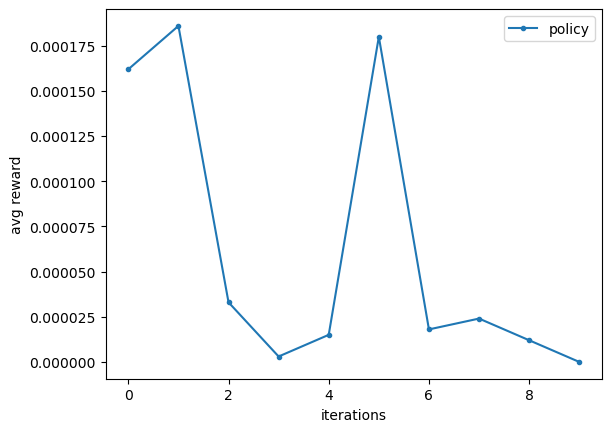

 55%|█████▌    | 110/200 [00:51<00:41,  2.14it/s]

In [ ]:
%reload_ext line_profiler
%lprun -f re_normalize_possible_actions_chunk perform()

### Random policy reward

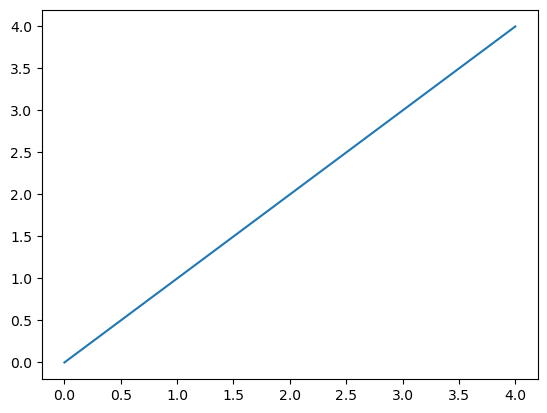

KeyboardInterrupt: 

In [132]:
import time

for i in range(100):
    clear_output(wait=True)
    a = np.arange(100)
    plt.plot(a[:i])
    plt.show()
    time.sleep(1)

In [91]:
random_env_ = NumpyEnvironment(100)
random_env_.FRUIT_REWARD = .5
random_env_.ATE_HIMSELF_REWARD = .2
random_env_.WIN_REWARD = 1.
random_env_.STEP_REWARD = -0.01
GAMMA = .99
ITERATIONS = 10000
EPSILON=0.1
random_rewards = []

for _ in trange(100):
    state = random_env_.to_state()
    probs = re_normalize_possible_actions(
        state,
        tf.repeat([[.25]*4],100, axis=0)
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = random_env_.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

100%|██████████| 100/100 [00:02<00:00, 37.37it/s]


## Training evaluation

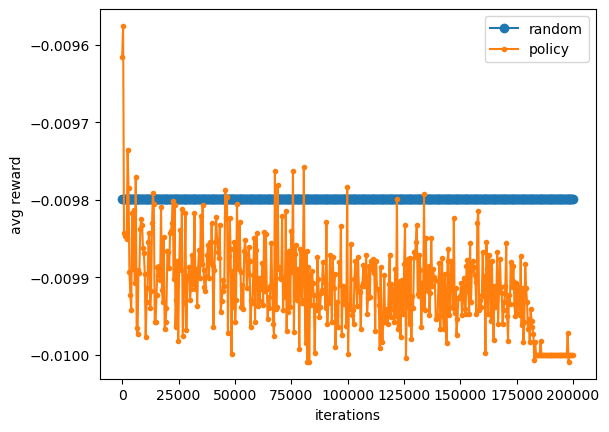

In [92]:
%matplotlib inline

CHUNK_SIZE = 20
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

## Test (graphical simulation)

In [147]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [148]:
test_env = NumpyEnvironment(2)

In [149]:
def animate(frame):
    state = test_env.to_state()
    original_probs = agent(
        state
    )
    probs = re_normalize_possible_actions(
        state,
        original_probs
    )
    actions = tf.random.categorical(tf.math.log(probs),1)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [150]:
fig, axs = plt.subplots(1,2)
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>